In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy import stats

In [2]:
inputs = pd.read_csv('data/txs_inputs.csv')
outputs = pd.read_csv('data/txs_outputs.csv')
addressMap = pd.read_csv('data/txs_addr_map.csv')
dustInputs = inputs[(inputs.amount >= 1) & (inputs.amount <= 545)]
dustOutputs = outputs[(outputs.amount >= 1) & (outputs.amount <= 545)]

# Transaction analysis

In this section, we study the general properties of all dust-creating and dust-consuming transactions.

We first count how many dust-creating and dust-consuming transactions are comprised in our data set.

In [43]:
dustCreatingIds = dustOutputs.txId.unique()
dustConsumingIds = dustInputs.txId.unique()
bothIds = np.intersect1d(dustCreatingIds, dustConsumingIds)
totalIds = np.union1d(dustCreatingIds, dustConsumingIds)
print('N. of transactions:\t{}\nN. of dust-creating:\t{}\nN. of dust-creating:\t{}\nN. of both:\t\t{}'.format(len(totalIds), len(dustCreatingIds), len(dustConsumingIds), len(bothIds)))

N. of transactions:	2114335
N. of dust-creating:	1705560
N. of dust-creating:	429544
N. of both:		20769


We then compute the following values:

- Average number of dust outputs (resp. inputs) for dust-creating (resp. dust-consuming) TXs.
- Average percentage of dust outputs (resp. inputs) for dust-consuming (resp. dust-creating) TXs.

In [4]:
outInfo = pd.DataFrame({'numOut': outputs.txId.value_counts()}).reset_index(names=['txId'])
tmp = pd.DataFrame({'numDustOut': dustOutputs.txId.value_counts()}).reset_index(names=['txId'])
outInfo = outInfo.merge(tmp, how='left', on='txId').fillna(0).astype(int)
outInfo['percentage'] = outInfo['numDustOut']/outInfo['numOut']

inInfo = pd.DataFrame({'numIn': inputs.txId.value_counts()}).reset_index(names=['txId'])
tmp = pd.DataFrame({'numDustIn': dustInputs.txId.value_counts()}).reset_index(names=['txId'])
inInfo = inInfo.merge(tmp, how='left', on='txId').fillna(0).astype(int)
inInfo['percentage'] = inInfo['numDustIn']/inInfo['numIn']

avgNumDustOut = np.mean(outInfo[outInfo.numDustOut > 0].numDustOut)
avgNumDustIn = np.mean(inInfo[inInfo.numDustIn > 0].numDustIn)

avgDustOutPerc = np.mean(outInfo[outInfo.numDustOut > 0].percentage) * 100
avgDustInPerc = np.mean(inInfo[inInfo.numDustIn > 0].percentage) * 100

print('Avg. number of dust inputs:\t{}\nAvg. number of dust outputs:\t{}'.format(avgNumDustIn, avgNumDustOut))
print('Avg. perc. of dust inputs:\t{}\nAvg. perc. of dust outputs:\t{}'.format(avgDustInPerc, avgDustOutPerc))

Avg. number of dust inputs:	5.982730523531932
Avg. number of dust outputs:	2.5802416801519734
Avg. perc. of dust inputs:	35.83353426702955
Avg. perc. of dust outputs:	50.22264031591179


Then, we create four different plots.

1. The first plot shows the frequency of the number of dust outputs in dust-creating transactions.
2. The second plot shows the frequency of the number of dust inputs in dust-consuming transactions.
3. The third plot shows the composition (i.e., the subdivision between dust and non-dust) of outputs of dust-creating transactions.
4. The fourth plot shows the composition of inputs for dust-consuming transactions.

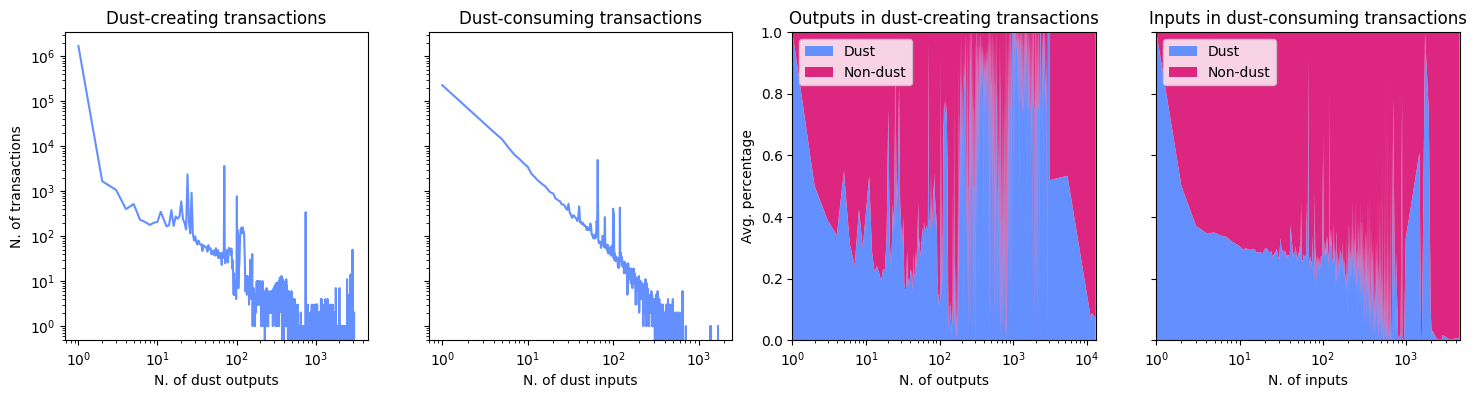

In [20]:
def computePercentages(df_total, df_dust):
    d1 = pd.DataFrame({'numDustOut': df_dust.groupby('txId').size()})
    d2 = pd.DataFrame({'numOut': df_total.groupby('txId').size()})
    tmp1 = d1.merge(d2, on='txId', how='left').fillna(0)
    tmp1['dustPerc'] = tmp1['numDustOut'] / tmp1['numOut']
    tmp2 = tmp1.groupby('numOut').dustPerc.mean()
    return pd.DataFrame({'dustPerc': tmp2, 'nonDustPerc': 1-tmp2})

# Compute data for the first two plots.
data_out = dustOutputs.groupby('txId').size().values
data_in = dustInputs.groupby('txId').size().values
hist_out, bins_out = np.histogram(data_out, bins=np.arange(1, np.max(data_out)+1))
hist_in, bins_in = np.histogram(data_in, bins=np.arange(1, np.max(data_in)+1))

# Compute data for the last two plots.
stack_in = computePercentages(inputs, dustInputs)
stack_out = computePercentages(outputs, dustOutputs)

fig = plt.figure(figsize=(18,4))

ax1 = fig.add_subplot(1, 4, 1)
ax1.set_title('Dust-creating transactions')
ax1.set_xlabel('N. of dust outputs')
ax1.set_ylabel('N. of transactions')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(bins_out[:-1], hist_out, color='#648fff')

ax2 = fig.add_subplot(1, 4, 2, sharey=ax1)
ax2.set_title('Dust-consuming transactions')
ax2.set_xlabel('N. of dust inputs')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(bins_in[:-1], hist_in, color='#648fff')

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title('Outputs in dust-creating transactions')
ax3.set_xlabel('N. of outputs')
ax3.set_ylabel('Avg. percentage')
ax3.set_xscale('log')
ax3.margins(0,0)
ax3.stackplot(stack_out.index, stack_out['dustPerc'], stack_out['nonDustPerc'], 
              colors=['#648fff', '#dc267f'], labels=['Dust', 'Non-dust'])
ax3.legend(loc='upper left')

ax4 = fig.add_subplot(1, 4, 4, sharey=ax3)
ax4.set_title('Inputs in dust-consuming transactions')
ax4.set_xlabel('N. of inputs')
ax4.set_xscale('log')
ax4.margins(0,0)
ax4.stackplot(stack_in.index, stack_in['dustPerc'], stack_in['nonDustPerc'], 
              colors=['#648fff', '#dc267f'], labels=['Dust', 'Non-dust'])
ax4.legend(loc='upper left')

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.savefig("pictures/global.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Address analysis

In this section we analyze the top 5 dust _senders_ and _receivers_.

1) We identify the top senders by counting how many dust-creating TXs contain that address in their inputs.
2) We identify the top receivers by counting how many dust-consuming TXs include that address among their inputs.

In [53]:
tmp = inputs[inputs.txId.isin(dustCreatingIds)].groupby('address').txId.nunique().sort_values(ascending=False).head(5)
pd.DataFrame({'txCount':tmp}).reset_index().rename(columns={'address':'addrId'}).merge(addressMap, on='addrId', how='left')

,addrId,txCount,addrHash
0,3524394,374464,1dice8EMZmqKvrGE4Qc9bUFf9PX3xaYDp
1,3517636,177201,1dice97ECuByXAvqXpaYzSaQuPVvrtmz6
2,3525822,127790,1dice6YgEVBf88erBFra9BHf6ZMoyvG88
3,3534212,123005,1dice7fUkz5h4z2wPc1wLMPWgB5mDwKDx
4,3525858,93724,1dice1e6pdhLzzWQq7yMidf6j8eAg7pkY


In [41]:
topReceivers = dustOutputs.groupby('address').agg({'txId' : 'nunique'}).sort_values(by='txId', ascending=False).head(5).reset_index()
topReceivers = topReceivers.reset_index(drop=True).rename(columns={'address':'addrId', 'txId':'txCount'})
topReceivers.merge(addressMap, on='addrId', how='left')

,addrId,txCount,addrHash
0,7470171,14337,1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN
1,5483937,11131,15tcsumFPsrw2p9Egmk7wGszFJVxpw7UiD
2,2931635,8099,18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B
3,8080430,7628,14z1fVwxMG71WcijX9J9te8G1wyp7tVqdz
4,4437657,3739,1FE1CDgkqzMSFXFreXrET7hvhEfCP9QabY


# Output analysis

## Output classification

We now classify dust outputs into 3 distinct groups:

1. unspent outputs (i.e., outputs that are still part of the UTXO set);
2. spent in combination with at least one non-dust output (NOD);
3. spent only in combination with other dust outputs (OD);

In [20]:
def classify(numIn, numDustIn):
    if (numIn - numDustIn > 0):
        return 'NOD'
    return 'OD'

d1 = pd.DataFrame({'numDustIn': dustInputs.groupby('txId').size()})
d2 = pd.DataFrame({'numIn': inputs.groupby('txId').size()})
dustConsumingTxs = d1.merge(d2, on='txId', how='left')
dustConsumingTxs['type'] = dustConsumingTxs.apply(lambda x: classify(x.numIn, x.numDustIn), axis=1)
dustConsumingTxs = dustConsumingTxs.reset_index().rename(columns={'txId': 'spentId'})
dustConsumingTxs = dustConsumingTxs[['spentId', 'type']]

dustInputs_mod = dustInputs[['txId', 'blockId', 'timestamp', 'prevTxId', 'address', 'amount', 'prevTxOffset']]
dustInputs_mod = dustInputs_mod.rename(columns = {'txId':'spentId', 'blockId':'spentBlock', 'timestamp':'spentTimestamp', 'prevTxId':'txId', 'prevTxOffset':'offset'})
dustOutputsClass = pd.merge(dustOutputs, dustInputs_mod, on=['txId', 'address', 'amount', 'offset'], how='left', indicator=False)
dustOutputsClass['spentId']=dustOutputsClass['spentId'].fillna(-1).astype(int)
dustOutputsClass['spentBlock']=dustOutputsClass['spentBlock'].fillna(-1).astype(int)
dustOutputsClass['spentTimestamp']=dustOutputsClass['spentTimestamp'].fillna(-1).astype(int)

dustOutputsClass = dustOutputsClass.merge(dustConsumingTxs, on='spentId', how='left').fillna('Unspent')
dustOutputsClass.to_csv('data/outputs_dust_class.csv', index=False)

For each category, we count the number of outputs.

In [3]:
dustOutputsClass = pd.read_csv('data/outputs_dust_class.csv')
dustOutputsClass['timestamp'] = dustOutputsClass['timestamp'].astype(dtype='datetime64[s]')
dustOutputsClass['spentTimestamp'] = dustOutputsClass['spentTimestamp'].astype(dtype='datetime64[s]')
dustOutputsClass.type.value_counts()

NOD        2420707
Unspent    1830911
OD          149139
Name: type, dtype: int64

## Output consumption

In this section we compute statistics concerning the consumption of dust and non-dust outputs.

We define duration as the difference $b_c - b_0$ between the identifier $b_0$ of the block where the output was created and $b_c$, i.e. the identifier of the block where the output has been consumed.

In [21]:
df = pd.read_csv('data/outputs_spent_stats.csv')
df

,duration,dust,nonDust,dustPerc,nonDustPerc
0,0,106868,72346052,0.001475,0.998525
1,1,60290,47498191,0.001268,0.998732
2,2,56378,31350059,0.001795,0.998205
3,3,49314,20920674,0.002352,0.997648
4,4,41333,14826687,0.002780,0.997220
...,...,...,...,...,...
475812,475812,0,0,0.000000,0.000000
475813,475813,0,0,0.000000,0.000000
475814,475814,0,0,0.000000,0.000000
475815,475815,0,0,0.000000,0.000000


We compute the average duration (i.e., number of blocks) for dust and non-dust outputs.

In [22]:
x = df[df.dust > 0]
y = df[df.nonDust > 0]
m1 = np.sum(x.duration * x.dust) / np.sum(x.dust)
m2 = np.sum(y.duration * y.nonDust) / np.sum(y.nonDust)
print(f'Avg. duration for dust: {m1}\nAvg. duration for non-dust: {m2}')

Avg. duration for dust: 25165.333078713666
Avg. duration for non-dust: 3207.3614089929624


We create two plots to better analyze the output durations.

1. The leftmost plot is a histogram representing the duration distributions for dust and non-dust outputs.
2. The rightmost plot is a stacked histogram. 

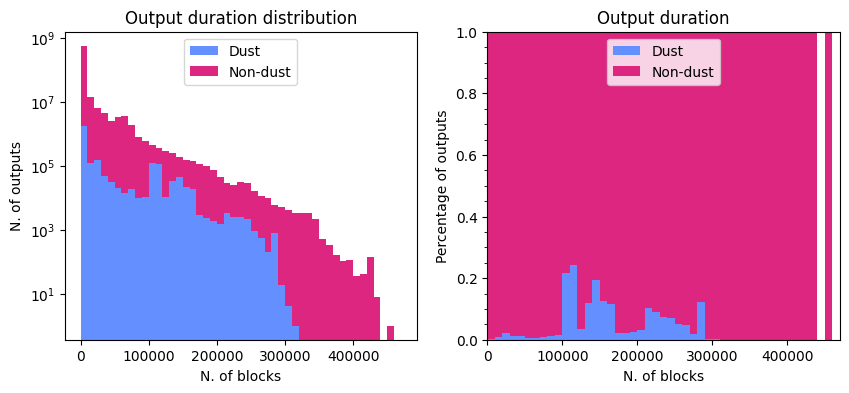

In [23]:
width = 10000
histBins = range(0, np.max(df.duration) + width, width)
stDust = stats.binned_statistic(df.duration, df.dust, statistic='sum', bins=histBins)
stNonDust = stats.binned_statistic(df.duration, df.nonDust, statistic='sum', bins=histBins)
x = pd.DataFrame({'bin':stDust.bin_edges[:-1],'dust':stDust.statistic,'nonDust':stNonDust.statistic})
x['sum'] = x['dust'] + x['nonDust']
x['dustPerc'] = x['dust']/x['sum']
x['nonDustPerc'] = x['nonDust']/x['sum']
x = x.fillna(0)

fig = plt.figure(figsize=(10,4))
fig.tight_layout()

# Leftmost plot
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output duration distribution')
ax1.set_xlabel('N. of blocks')
ax1.set_ylabel('N. of outputs')
ax1.set_yscale('log')
ax1.stairs(x.nonDust[:-1], x.bin, color='#dc267f', fill=True, label='Non-dust')
ax1.stairs(x.dust[:-1], x.bin, color='#648fff', fill=True, label='Dust')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper center') 

# Rightmost plot
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Output duration')
ax2.set_ylabel('Percentage of outputs')
ax2.set_xlabel('N. of blocks')
ax2.stackplot(x.bin, x['dustPerc'], x['nonDustPerc'], colors=['#648fff','#dc267f'], labels=['Dust', 'Non-dust'], step='post')
ax2.legend(loc='upper center')
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))
#ax2.axis([0, 470000, 0, 0.3])
ax2.margins(0,0)

plt.savefig("pictures/output-lifecycle.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Temporal analysis

In this section we conduct a temporal analysis of output expenditure.

In [5]:
NOD = dustOutputsClass[dustOutputsClass.type == 'NOD']
OD = dustOutputsClass[dustOutputsClass.type == 'OD']
SatoshiDiceAddresses = addressMap[addressMap.addrHash.str.contains('1dice', regex=False)].addrId.values
SatoshiDiceTxs = inputs[inputs.address.isin(SatoshiDiceAddresses)].txId.unique()

First, we list the top 5 addresses in terms of NOD output consumption.

Then, for each address, we also count how many of those outputs have been sent by a Satoshi Dice address.

In [18]:
x1 = pd.DataFrame({'count': NOD.address.value_counts().head(5)}).reset_index(names='addrId')
x2 = pd.DataFrame({'sentBySD':tmp.groupby('address').size()}).reset_index(names='addrId')
x3 = x1.merge(x2, on='addrId', how='left').merge(addressMap, on='addrId', how='left')

,addrId,count,sentBySD,addrHash
0,7470171,12502,10758.0,1PEDJAibfNetJzM289oXsW1qLAgjYDjLgN
1,8080430,7628,7626.0,14z1fVwxMG71WcijX9J9te8G1wyp7tVqdz
2,2931635,7288,NaN,18d3HV2bm94UyY4a9DrPfoZ17sXuiDQq2B
3,8299015,3614,3268.0,1GmREU2gwcvQHRQFgwHvbD4dyL8iryCPMY
4,10241823,3526,3526.0,1dES7RLppoYc8mLQedwUoJMZZ9RnuCP5f


Finally, we produce a plot describing how the consumption of OD and NOD outputs has evolved over time, i.e., from 2009 to August 2017. In the rightmost plot, we present the detailed consumption for the year 2013, as it is the one where an important peak has been observed.

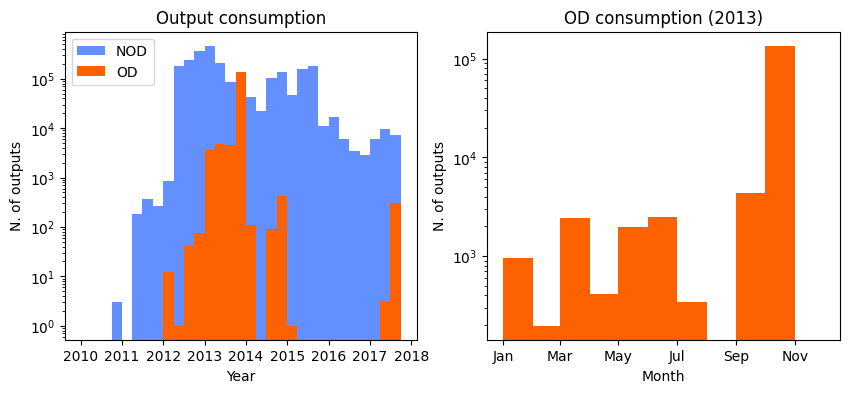

In [19]:
NOD_data = NOD.spentTimestamp.values
OD_data = OD.spentTimestamp.values
OD_2013_data = OD[OD.spentTimestamp.dt.year == 2013].spentTimestamp.values

histBins_all = [datetime.date(y, m, 1) for y in range(2010, 2018, 1) for m in range(1, 12+1, 3)]
histBins_2013 = [datetime.date(2013, i, 1) for i in range(1, 12+1)]

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Output consumption')
ax1.set_xlabel('Year')
ax1.set_ylabel('N. of outputs')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.hist(NOD_data, bins=histBins_all, color='#648fff', label='NOD')
ax1.hist(OD_data, bins=histBins_all, color='#fe6100', label='OD')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('OD consumption (2013)')
ax2.set_xlabel('Month')
ax2.set_ylabel('N. of outputs')
ax2.set_yscale('log')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.hist(OD_2013_data, bins=histBins_2013, color='#fe6100', label='OD')

plt.savefig("pictures/temporal.pdf", format='pdf', bbox_inches='tight')
plt.show()